In [154]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from random import randint
import os
import pickle
from tqdm.notebook import tqdm

In [155]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

    def save(self, filename):
        raise NotImplementedError


In [156]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights.T) + self.bias.T

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(output_gradient, self.weights)
        weights_gradient = np.dot(output_gradient.T, self.input)
        bias_gradient = np.sum(output_gradient, axis=0, keepdims=True).T
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * bias_gradient
        return input_gradient

class Dropout(Layer):
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate
        self.mask = None

    def forward(self, input):
        self.mask = np.random.rand(*input.shape) > self.drop_rate
        return input * self.mask

    def backward(self, output_gradient, learning_rate):
        return output_gradient * self.mask


In [157]:
layer = Dense(897, 64)
layer2 = Dense(64, 4)
result = layer.forward(x_train[:32])
result = layer2.forward(result)

loss = MeanSquaredError()
loss_gradient = loss.gradient(y_train[:32], result)
# print(loss_gradient.shape) # (32, 4)
result = layer2.backward(loss_gradient, 0.001)
result = layer.backward(result, 0.001)
result

array([[-29.18553587, -11.99122174,  13.30684247, ..., -19.51583263,
         -6.08208852,   5.3645683 ],
       [  7.26055746,  -7.65404295,   5.68087853, ..., -11.85472547,
         -5.86516663,   4.24094889],
       [ 43.89823154, -20.06912804,  24.45650413, ..., -25.36360383,
        -16.54573236,   7.52945217],
       ...,
       [ 11.25690671, -12.197378  ,   6.97818049, ..., -15.38594739,
         -8.20126499,   6.31887138],
       [ 12.87099292, -18.88796095,   2.17402861, ..., -18.59977956,
        -10.29938853,  10.43551226],
       [  1.37197798, -19.8413537 ,   4.40858038, ..., -16.6046752 ,
         -9.02314732,   9.51797898]])

In [158]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class Tanh(Activation):
    @staticmethod
    def activation(x):
        return np.tanh(x)

    @staticmethod
    def activation_prime(x):
        return 1 - np.tanh(x) ** 2

    def __init__(self):
        super().__init__(Tanh.activation, Tanh.activation_prime)

class Sigmoid(Activation):

    @staticmethod
    def activation(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def activation_prime(x):
        sig = Sigmoid.activation(x)
        return sig * (1 - sig)

    def __init__(self):
        super().__init__(Sigmoid.activation, Sigmoid.activation_prime)

class ReLU(Activation):
    @staticmethod
    def activation(x):
        return np.maximum(0, x)

    @staticmethod
    def activation_prime(x):
        return np.where(x > 0, 1, 0)

    def __init__(self):
        super().__init__(ReLU.activation, ReLU.activation_prime)

class Softmax(Activation):
    @staticmethod
    def activation(x):
        exp = np.exp(x)
        return exp / np.sum(exp, axis=0)

    @staticmethod
    def activation_prime(x):
        return 1

    def __init__(self):
        super().__init__(Softmax.activation, Softmax.activation_prime)


In [159]:
class Loss:
    def loss(self, y_true, y_pred):
        raise NotImplementedError()

    def gradient(self, y_true, y_pred):
        raise NotImplementedError()

class MeanSquaredError(Loss):
    def loss(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))

    def gradient(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size

class BinaryCrossEntropy(Loss):
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        return -np.mean(np.multiply(y_true, np.log(y_pred + epsilon)) + np.multiply(1 - y_true, np.log(1 - y_pred + epsilon)))

    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        return np.divide(y_pred - y_true, np.multiply(y_pred + epsilon, 1 - y_pred + epsilon))

class CategoricalCrossEntropy(Loss):
    def loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return y_pred - y_true


In [160]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, layer):
        raise NotImplementedError()

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, weights, gradients):
        for w, grad in zip(weights, gradients):
            w -= self.learning_rate * grad

class Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = None  # First moment vector
        self.v = None  # Second moment vector
        self.t = 0     # Time step

    def update(self, weights, gradients):
        if self.m is None:
            self.m = [np.zeros_like(w) for w in weights]
        if self.v is None:
            self.v = [np.zeros_like(w) for w in weights]

        self.t += 1
        for i, (w, grad) in enumerate(zip(weights, gradients)):
            self.m[i] = self.beta_1 * self.m[i] + (1 - self.beta_1) * grad
            self.v[i] = self.beta_2 * self.v[i] + (1 - self.beta_2) * (grad ** 2)

            m_hat = self.m[i] / (1 - self.beta_1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta_2 ** self.t)

            w -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)


In [161]:
def test_model(model, x_test, y_test):
    correct = 0
    predictions = np.argmax(model.predict(x_test), axis=0)
    real = np.argmax(y_test, axis=0)
    correct = np.sum(predictions == real)
    return correct / len(x_test)

In [162]:
def test_across(model, x_test, y_test):
    predictions = [0, 0, 0, 0]
    count = [0, 0, 0, 0]
    success = [0, 0, 0, 0]
    for x, y in zip(x_test, y_test):
        output = model.predict_one(x)
        pred = np.argmax(output)
        predictions[pred] += 1
        real = np.argmax(y)
        count[real] += 1
        if pred == real:
            success[real] += 1
    return ([pred / count[i] for i, pred in enumerate(predictions)], [succ / count[i] for i, succ in enumerate(success)])

In [168]:
class Network(Layer):
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, output_error, learning_rate):
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error, learning_rate)
        return output_error

class Model:
    def __init__(self, network, loss, x_test, y_test):
        self.network = Network(network)
        self.loss = loss
        self.x_test = x_test
        self.y_test = y_test
        self.train_loss = []
        self.test_loss = []
        self.test_acc = []
    
    def train(self, x_train, y_train, epochs, batch_size=32, learning_rate=1, early_stop=-1, verbose=False):
        learning_rate /= len(x_train) / batch_size
        for epoch in range(epochs):
            perm = np.random.permutation(len(x_train))
            x_train = x_train[perm]
            y_train = y_train[perm]
            mean_loss = 0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                output = self.network.forward(x_batch)
                loss = self.loss.loss(y_batch, output)
                mean_loss += loss
                loss_gradient = self.loss.gradient(y_batch, output)
                self.network.backward(loss_gradient, learning_rate)
                if early_stop > 0 and len(self.test_acc) > early_stop and self.test_acc[-1] <= self.test_acc[-early_stop]:
                    return
            mean_loss /= len(x_train)
            self.train_loss.append(mean_loss)
            self.evaluate(self.x_test, self.y_test)
            
            if verbose:
                print(f"Epoch {epoch + 1} - Train loss: {round(self.train_loss[-1], 4)} - Test loss: {round(self.test_loss[-1], 4)} - Test acc: {round(self.test_acc[-1], 4)}")
    
    def evaluate(self, x_test, y_test):
        total_loss = 0
        correct_predictions = 0
        for x, y in zip(x_test, y_test):
            output = self.network.forward(x)
            total_loss += self.loss.loss(y, output)
            if np.argmax(output) == np.argmax(y):
                correct_predictions += 1
        avg_loss = total_loss / len(x_test)
        accuracy = correct_predictions / len(x_test)
        self.test_loss.append(avg_loss)
        self.test_acc.append(accuracy)

    def predict_one(self, x_test):
        return self.network.forward(x_test)

    def predict(self, x_test):
        y_pred = []
        for x in x_test:
            y_pred.append(self.network.forward(x))
        return np.array(y_pred).squeeze()

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            return pickle.load(f)


In [164]:
from parseGpt import load_chess_data

x, y = load_chess_data("datasets/balanced.txt")

print(x.shape)

def one_hot_encode(x):
    one_hot = np.zeros((x.shape[0], 69, 13))
    for i in range(x.shape[0]):
        for j in range(69):
            one_hot[i][j][x[i][j]] = 1
    return one_hot

def flatten(x):
    return x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def preprocess_data(x, y, split):
    x = one_hot_encode(x)
    x = flatten(x)
    x_train = x.reshape(x.shape[0], x.shape[1])
    y_train = y.reshape(y.shape[0], y.shape[1])
    perm = np.random.permutation(len(x_train))
    x_train = x_train[perm]
    y_train = y_train[perm]
    split_index = int(split * len(x_train))
    x_train, x_test = x_train[:split_index], x_train[split_index:]
    y_train, y_test = y_train[:split_index], y_train[split_index:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = preprocess_data(x, y, 0.95)

(96272, 69)


In [170]:
layers = [
    Dense(897, 100),
    Tanh(),
    Dropout(0.3),
    Dense(100, 4),
    Sigmoid()
]

model = Model(layers, BinaryCrossEntropy(), x_test, y_test)
test_model(model, x_test, y_test)
model.train(x_train, y_train, 100, batch_size=64, learning_rate=1, early_stop=10, verbose=True)

Epoch 1 - Train loss: 0.0356 - Test loss: 0.8212 - Test acc: 0.3434
Epoch 2 - Train loss: 0.0223 - Test loss: 0.6449 - Test acc: 0.3602
Epoch 3 - Train loss: 0.0186 - Test loss: 0.5572 - Test acc: 0.3833
Epoch 4 - Train loss: 0.0169 - Test loss: 0.5188 - Test acc: 0.398
Epoch 5 - Train loss: 0.0161 - Test loss: 0.504 - Test acc: 0.398
Epoch 6 - Train loss: 0.0157 - Test loss: 0.4975 - Test acc: 0.4051
Epoch 7 - Train loss: 0.0156 - Test loss: 0.4946 - Test acc: 0.4134
Epoch 8 - Train loss: 0.0155 - Test loss: 0.4911 - Test acc: 0.4258
Epoch 9 - Train loss: 0.0154 - Test loss: 0.4897 - Test acc: 0.4211
Epoch 10 - Train loss: 0.0154 - Test loss: 0.4892 - Test acc: 0.4192
Epoch 11 - Train loss: 0.0154 - Test loss: 0.4862 - Test acc: 0.4369
Epoch 12 - Train loss: 0.0153 - Test loss: 0.49 - Test acc: 0.425
Epoch 13 - Train loss: 0.0153 - Test loss: 0.4837 - Test acc: 0.4339
Epoch 14 - Train loss: 0.0153 - Test loss: 0.4835 - Test acc: 0.424
Epoch 15 - Train loss: 0.0152 - Test loss: 0.4829 

In [173]:
model.train(x_train, y_train, 100, batch_size=64, learning_rate=0.1, verbose=True)

Epoch 1 - Train loss: 0.0075 - Test loss: 0.4786 - Test acc: 0.4375
Epoch 2 - Train loss: 0.0075 - Test loss: 0.4778 - Test acc: 0.4414
Epoch 3 - Train loss: 0.0075 - Test loss: 0.4787 - Test acc: 0.4366
Epoch 4 - Train loss: 0.0075 - Test loss: 0.4781 - Test acc: 0.4387
Epoch 5 - Train loss: 0.0075 - Test loss: 0.4773 - Test acc: 0.4462
Epoch 6 - Train loss: 0.0075 - Test loss: 0.4774 - Test acc: 0.4412
Epoch 7 - Train loss: 0.0075 - Test loss: 0.4766 - Test acc: 0.4396
Epoch 8 - Train loss: 0.0075 - Test loss: 0.4768 - Test acc: 0.4437
Epoch 9 - Train loss: 0.0075 - Test loss: 0.476 - Test acc: 0.4412


KeyboardInterrupt: 

In [ ]:
model.save("models/model_no_hidden")

PicklingError: Can't pickle <class '__main__.Model'>: it's not the same object as __main__.Model

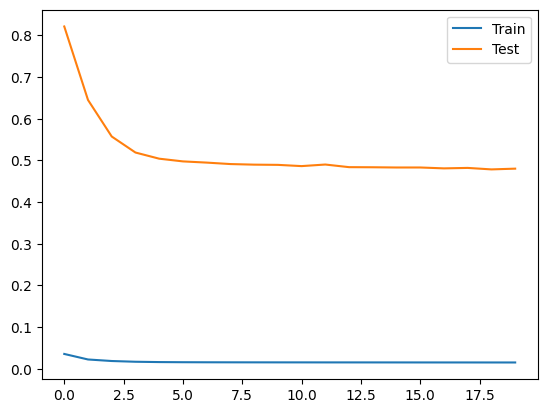

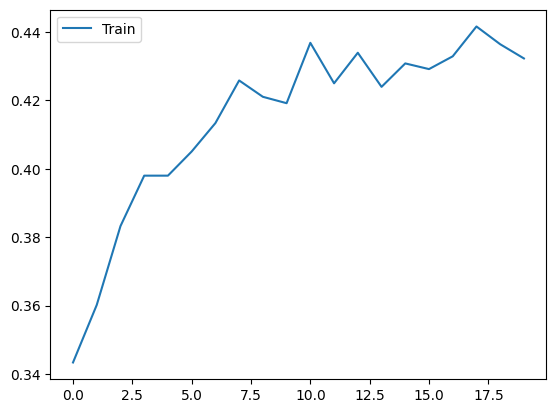

In [172]:
plt.plot(model.train_loss)
plt.plot(model.test_loss)
plt.legend(["Train", "Test"])
plt.show()

plt.plot(model.test_acc)
plt.legend(["Train", "Test"])
plt.show()

In [ ]:
model.save("model.npz")